In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

printFrequency = instanceParams["printFreq"]
batchSize = 1#instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

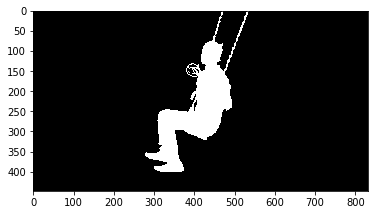

In [6]:
gt = np.zeros((480, 854))
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/swing/00043.png")[16:-16, 11:-11]
plt.imshow(gt, cmap='gray')

In [7]:
flow = np.zeros((448, 832, 2))

In [8]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

In [9]:
flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [10]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00043.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00044.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [12]:
rgb0 = rgb0[:,16:-16,11:-11,:]
rgb1 = rgb1[:,16:-16,11:-11,:]

In [19]:
lambdaTensor = tf.placeholder(tf.float32)
sLoss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, 1)

tLoss = pLoss + lambdaTensor * sLoss

In [20]:
sGrad = tf.gradients(sLoss, flow)
pGrad = tf.gradients(pLoss, flow)
tGrad = tf.gradients(tLoss, flow)

In [21]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [22]:
itr = 9000
solver, solver_op, learningRateTensor = attach_ADAM_Solver(tLoss)

In [25]:
init = tf.global_variables_initializer()
sLosses = []
pLosses = []
sGrads = []
pGrads = []
tGrads = []
flows = []
start_time = None
print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1,
            lambdaTensor: 2e4
        }
        _, p, s, f, sg = sess.run([solver_op, pLoss, sLoss, flow, sGrad], feed_dict = feed_dict)
        if i % print_freq == 1:
            print(i)
            pLosses.append(np.mean(p))
            sLosses.append(np.mean(s))
            flows.append(deepcopy(f[0]))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss: %f" % float(sLosses[-1])

1
Photo loss: 4162.661621
Smooth loss: 0.000004
11
Photo loss: 3784.786377
Smooth loss: 0.954696
21
Photo loss: 3604.541260
Smooth loss: 0.296749
31
Photo loss: 3550.106689
Smooth loss: 0.112178
41
Photo loss: 3494.647949
Smooth loss: 0.049642
51
Photo loss: 3441.701172
Smooth loss: 0.025815
61
Photo loss: 3399.769531
Smooth loss: 0.017236
71
Photo loss: 3365.356201
Smooth loss: 0.014311
81
Photo loss: 3336.697510
Smooth loss: 0.013430
91
Photo loss: 3311.303467
Smooth loss: 0.013313
101
Photo loss: 3288.756104
Smooth loss: 0.013433
111
Photo loss: 3265.265381
Smooth loss: 0.013710
121
Photo loss: 3242.244385
Smooth loss: 0.014057
131
Photo loss: 3220.715576
Smooth loss: 0.014374
141
Photo loss: 3200.398682
Smooth loss: 0.014697
151
Photo loss: 3180.300781
Smooth loss: 0.014983
161
Photo loss: 3160.735840
Smooth loss: 0.015255
171
Photo loss: 3141.628662
Smooth loss: 0.015514
181
Photo loss: 3123.288818
Smooth loss: 0.015747
191
Photo loss: 3104.311768
Smooth loss: 0.015968
201
Photo l

1641
Photo loss: 1147.470093
Smooth loss: 0.031498
1651
Photo loss: 1143.588745
Smooth loss: 0.031542
1661
Photo loss: 1139.863159
Smooth loss: 0.031977
1671
Photo loss: 1136.250732
Smooth loss: 0.031968
1681
Photo loss: 1132.587280
Smooth loss: 0.031786
1691
Photo loss: 1129.244629
Smooth loss: 0.031700
1701
Photo loss: 1126.034058
Smooth loss: 0.031496
1711
Photo loss: 1122.774048
Smooth loss: 0.031704
1721
Photo loss: 1119.625732
Smooth loss: 0.032399
1731
Photo loss: 1116.446411
Smooth loss: 0.032044
1741
Photo loss: 1113.574585
Smooth loss: 0.031776
1751
Photo loss: 1110.462769
Smooth loss: 0.031805
1761
Photo loss: 1107.647339
Smooth loss: 0.031913
1771
Photo loss: 1104.351562
Smooth loss: 0.031855
1781
Photo loss: 1101.448120
Smooth loss: 0.032280
1791
Photo loss: 1098.482178
Smooth loss: 0.032057
1801
Photo loss: 1095.400635
Smooth loss: 0.032093
1811
Photo loss: 1092.333130
Smooth loss: 0.032218
1821
Photo loss: 1089.246338
Smooth loss: 0.031728
1831
Photo loss: 1086.196045
Sm

3281
Photo loss: 796.715576
Smooth loss: 0.034762
3291
Photo loss: 795.100281
Smooth loss: 0.034465
3301
Photo loss: 793.533081
Smooth loss: 0.034780
3311
Photo loss: 792.027649
Smooth loss: 0.034800
3321
Photo loss: 790.476379
Smooth loss: 0.034482
3331
Photo loss: 789.137024
Smooth loss: 0.034064
3341
Photo loss: 787.711365
Smooth loss: 0.034718
3351
Photo loss: 786.241760
Smooth loss: 0.034856
3361
Photo loss: 785.097168
Smooth loss: 0.034932
3371
Photo loss: 783.945374
Smooth loss: 0.034979
3381
Photo loss: 782.989075
Smooth loss: 0.035223
3391
Photo loss: 781.756897
Smooth loss: 0.034897
3401
Photo loss: 780.672119
Smooth loss: 0.034795
3411
Photo loss: 779.683350
Smooth loss: 0.034519
3421
Photo loss: 778.715210
Smooth loss: 0.034190
3431
Photo loss: 777.852783
Smooth loss: 0.034902
3441
Photo loss: 776.893616
Smooth loss: 0.035823
3451
Photo loss: 775.847717
Smooth loss: 0.035315
3461
Photo loss: 774.692993
Smooth loss: 0.034579
3471
Photo loss: 773.636841
Smooth loss: 0.034666


4921
Photo loss: 698.554932
Smooth loss: 0.036225
4931
Photo loss: 698.192200
Smooth loss: 0.035691
4941
Photo loss: 697.687866
Smooth loss: 0.036197
4951
Photo loss: 697.352051
Smooth loss: 0.036466
4961
Photo loss: 696.985046
Smooth loss: 0.036082
4971
Photo loss: 696.544861
Smooth loss: 0.036274
4981
Photo loss: 696.191895
Smooth loss: 0.035982
4991
Photo loss: 695.627502
Smooth loss: 0.035693
5001
Photo loss: 695.761780
Smooth loss: 0.036491
5011
Photo loss: 695.870911
Smooth loss: 0.036367
5021
Photo loss: 695.674683
Smooth loss: 0.036108
5031
Photo loss: 695.348999
Smooth loss: 0.036138
5041
Photo loss: 695.012634
Smooth loss: 0.036032
5051
Photo loss: 694.840759
Smooth loss: 0.036169
5061
Photo loss: 694.493591
Smooth loss: 0.036096
5071
Photo loss: 694.278870
Smooth loss: 0.036099
5081
Photo loss: 693.998352
Smooth loss: 0.035971
5091
Photo loss: 693.631409
Smooth loss: 0.036201
5101
Photo loss: 693.367126
Smooth loss: 0.036343
5111
Photo loss: 693.083984
Smooth loss: 0.036624


6561
Photo loss: 635.855469
Smooth loss: 0.034594
6571
Photo loss: 635.779175
Smooth loss: 0.034828
6581
Photo loss: 635.727661
Smooth loss: 0.034717
6591
Photo loss: 635.789062
Smooth loss: 0.034559
6601
Photo loss: 635.734009
Smooth loss: 0.034442
6611
Photo loss: 635.591736
Smooth loss: 0.034327
6621
Photo loss: 635.525818
Smooth loss: 0.035315
6631
Photo loss: 635.252258
Smooth loss: 0.035293
6641
Photo loss: 635.304260
Smooth loss: 0.034922
6651
Photo loss: 635.228516
Smooth loss: 0.034746
6661
Photo loss: 635.161560
Smooth loss: 0.033919
6671
Photo loss: 635.203491
Smooth loss: 0.034149
6681
Photo loss: 635.253357
Smooth loss: 0.034881
6691
Photo loss: 635.105164
Smooth loss: 0.035190
6701
Photo loss: 634.927002
Smooth loss: 0.034691
6711
Photo loss: 634.928955
Smooth loss: 0.034376
6721
Photo loss: 634.885864
Smooth loss: 0.034231
6731
Photo loss: 634.791443
Smooth loss: 0.034687
6741
Photo loss: 634.810852
Smooth loss: 0.035521
6751
Photo loss: 634.729309
Smooth loss: 0.035196


8201
Photo loss: 630.742065
Smooth loss: 0.033803
8211
Photo loss: 630.855164
Smooth loss: 0.034483
8221
Photo loss: 630.774231
Smooth loss: 0.035039
8231
Photo loss: 630.835815
Smooth loss: 0.035137
8241
Photo loss: 630.743774
Smooth loss: 0.034821
8251
Photo loss: 630.713928
Smooth loss: 0.034767
8261
Photo loss: 630.756287
Smooth loss: 0.034504
8271
Photo loss: 630.701782
Smooth loss: 0.035209
8281
Photo loss: 630.494751
Smooth loss: 0.035502
8291
Photo loss: 630.501099
Smooth loss: 0.034854
8301
Photo loss: 630.488037
Smooth loss: 0.034814
8311
Photo loss: 630.365051
Smooth loss: 0.034843
8321
Photo loss: 630.518616
Smooth loss: 0.034588
8331
Photo loss: 630.310852
Smooth loss: 0.034599
8341
Photo loss: 630.435608
Smooth loss: 0.034337
8351
Photo loss: 630.336182
Smooth loss: 0.035204
8361
Photo loss: 630.394531
Smooth loss: 0.035473
8371
Photo loss: 630.374695
Smooth loss: 0.034737
8381
Photo loss: 630.225586
Smooth loss: 0.035091
8391
Photo loss: 630.362488
Smooth loss: 0.034743


In [17]:
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
tLosses = pLosses + 1000 * sLosses

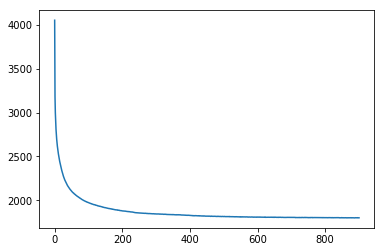

In [18]:
plt.plot(tLosses)

In [19]:
# np.save("swing_sgd_lambda10k", tLosses)
# np.save("swing_adam_lambda10k", tLosses)
np.save("swing_sgd_lambda1k", tLosses)
# np.save("swing_adam_lambda1k", tLosses)